# Infectious Disease Dynamics: Final Project

In [1]:
import numpy as np
from scipy.special import logit
import matplotlib.pyplot as plt

from numpy.random import default_rng

rng = default_rng(seed=42)

from mcmc_basic import (
    run_one_timestep,
    initialize_array,
    calc_log_likelihood,
    proposal_draw,
    run_mcmc,   
)
# from sir_aug import sir_out
from sir_basic import sir_out
from constants import (
    DEFAULT_NUM_PARTICLES,
    DEFAULT_NUM_TIME_STEPS,
)

In [2]:
horrible_guess = -1e10

target_beta = 2 / 5
target_gamma = 1 / 5
target_s_init = 0.95
target_i_init = 0.01
target_rho = 0.5
target_season = .9
target_peak = 6

target_vector = np.array([
    np.log(target_beta),
    np.log(target_gamma),
    logit(target_s_init),
    logit(target_i_init / (1 - target_s_init)),
    logit(target_rho),
    logit(target_season),
    logit(target_peak / 12)
])

proposal_standard_dev = np.array([0.05, 0.05, 0.2, 0.2, 0.2, 0.2, 0.2])
num_params = len(proposal_standard_dev)

# Run the simulation
data = sir_out(target_vector, rng=rng)


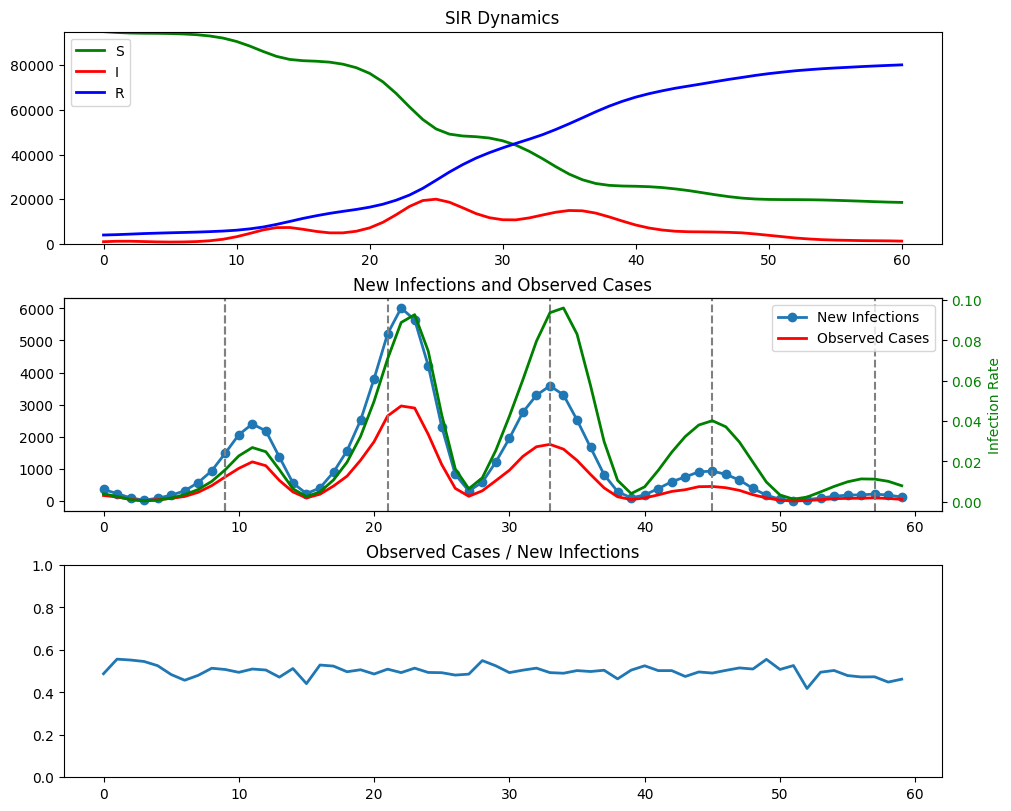

In [3]:
# Set up 3 vertically stacked plots with consistent margins
fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

# First plot: S, I, R over time
axs[0].plot(data[:, 0], label='S', color='green', linewidth=2)
axs[0].plot(data[:, 1], label='I', color='red', linewidth=2)
axs[0].plot(data[:, 2], label='R', color='blue', linewidth=2)
axs[0].set_ylim(0, np.nanmax(data[:, 0:3]))
axs[0].set_title("SIR Dynamics")
axs[0].legend()

# Second plot: New Infections and Observed Cases
axs[1].plot(data[:, 3], marker='o', linestyle='-', linewidth=2, label='New Infections')
axs[1].plot(data[:, 5], color='red', linewidth=2, label='Observed Cases')

axs[1].axvline(x=9, linestyle='--', color='gray')  # equivalent to abline at v=9,21,33,45,57
for x in range(9, 9 + 12 * 4 + 1, 12):
    axs[1].axvline(x=x, linestyle='--', color='gray')

axs[1].set_title("New Infections and Observed Cases")
axs[1].legend(loc='upper right')

# Overlay the infection rate curve from column 6
ax2 = axs[1].twinx()
ax2.plot(data[:, 6], color='green', linewidth=2, label='Infection Rate')

ax2.set_ylabel("Infection Rate", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Third plot: Observed / New Infections (reporting rate estimate)
ratio = np.divide(data[:, 5], data[:, 3], out=np.zeros_like(data[:, 5]), where=data[:, 3]!=0)

axs[2].plot(ratio, linewidth=2)
axs[2].set_ylim(0, 1)
axs[2].set_title("Observed Cases / New Infections")

plt.show()

# Equivalent to R: observed_data <- head(data[,6], -1)
observed_data = data[:-1, 5]


In [4]:
current_params = proposal_draw(
    proposal_standard_dev=proposal_standard_dev,
    rng=rng,
)
# current_params = target_vector  # if you want to start at target_vector instead

current_run = calc_log_likelihood(
    params=current_params,
    observed_data=observed_data,
    rng=rng,
)
current_log_likelihood = current_run[0]

try_a_bunch = 100
guess_attempt = 1

while guess_attempt < try_a_bunch and current_log_likelihood <= horrible_guess:
    current_params = proposal_draw(proposal_standard_dev, rng=rng)
    current_run = calc_log_likelihood(current_params, observed_data, rng=rng)
    current_log_likelihood = current_run[0]
    guess_attempt += 1

current_latent = current_run[1]

chain = current_params.reshape((num_params, 1))
latents = [current_latent]
accept_chain = [0]  # Use list to accumulate
all_steps = {
    "chain": chain,
    "latents": latents,
    "accept_chain": accept_chain,
    "log_likelihood": [current_log_likelihood],
    "current_latent": current_latent,
}

In [ ]:
# Running MCMC steps
all_steps = run_mcmc(
    5000,
    all_steps,
    np.array([1, 1, 1, 1, .1, .1, .1]),  # Proposal SDs, adjust as needed
    observed_data,
    rng=rng,
)

In [ ]:
target_vector

array([-0.91629073, -1.60943791,  2.94443898, -1.38629436,  0.        ,
        2.19722458,  0.        ])

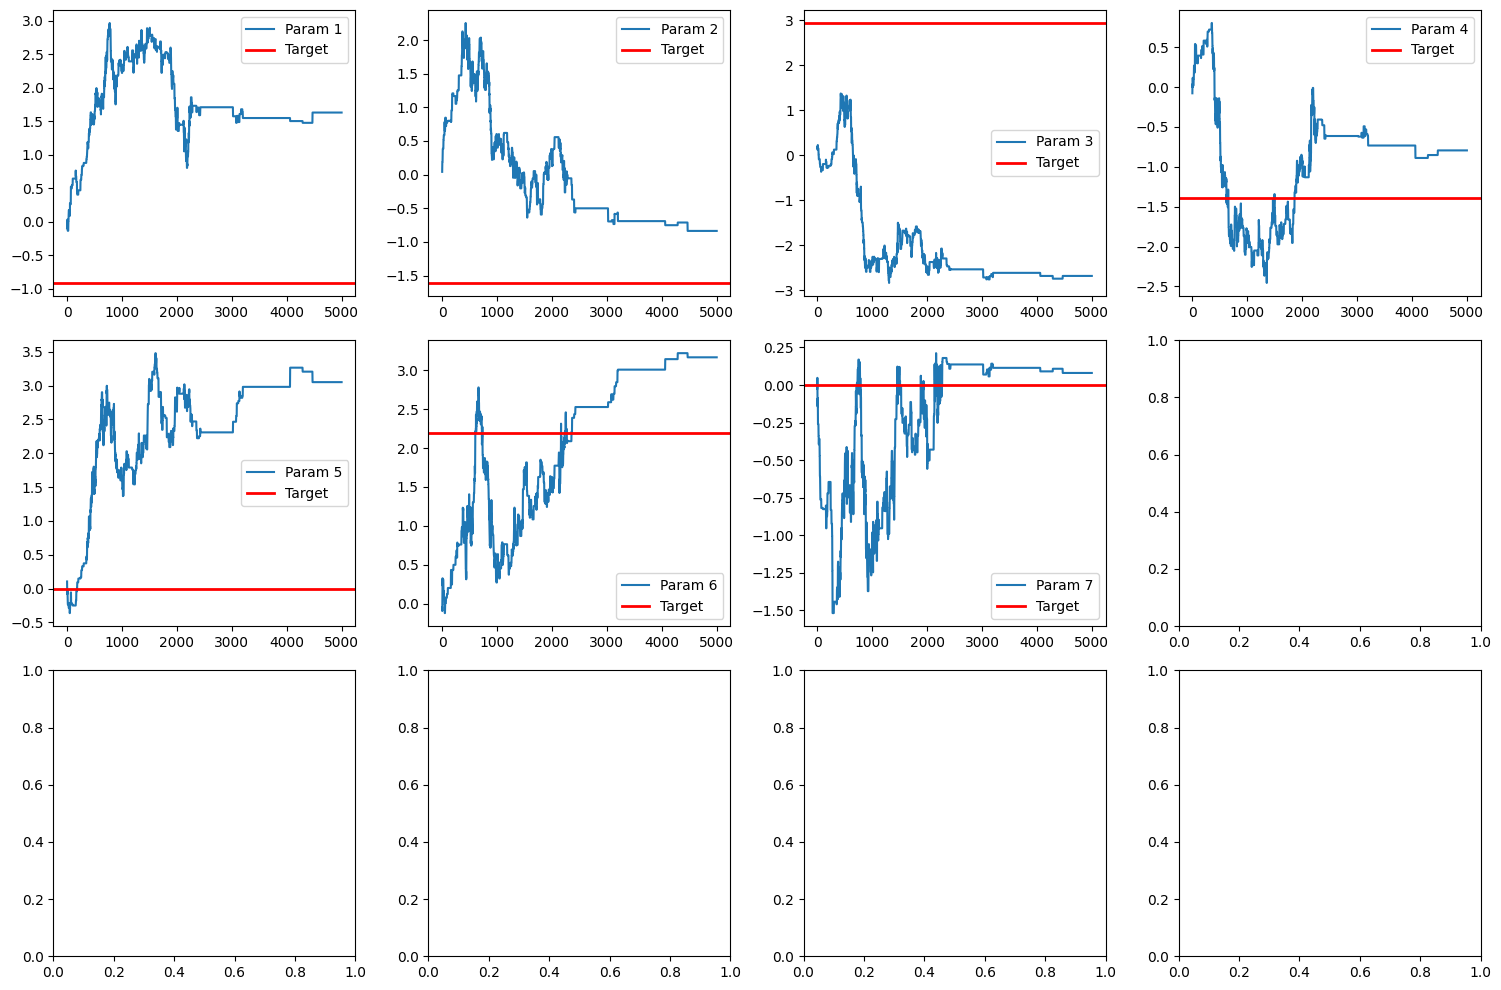

In [ ]:
# Plotting parameter chains with target lines
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 cols layout
axs = axs.flatten()

for par_num in range(num_params):
    # ylim = (np.min(all_steps["chain"][par_num, :]), np.max(all_steps["chain"][par_num, :]))
    axs[par_num].plot(all_steps["chain"][par_num, :], label=f"Param {par_num+1}")
    axs[par_num].axhline(target_vector[par_num], color='red', linewidth=2, label="Target")
    # axs[par_num].set_ylim(ylim)
    axs[par_num].legend()

plt.tight_layout()
plt.show()


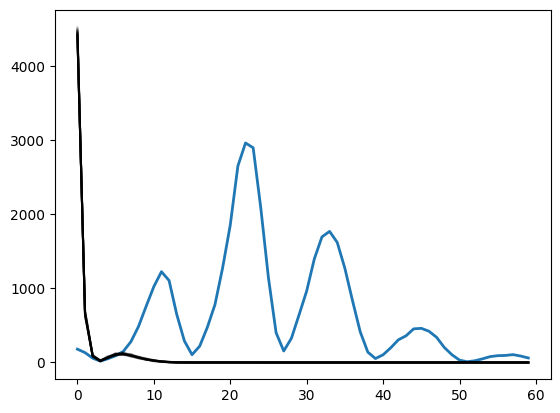

In [ ]:
# Plot observed data
plt.figure()
plt.plot(data[:, 5], linewidth=2)  # data[,6] in R is data[:,5] in Python (0-indexed)

for _ in range(40):
    out = sir_out(all_steps["chain"][:, -1], rng=rng)
    plt.plot(out[:, 5], color=(0, 0, 0, 0.1))  # black with alpha=0.1

plt.show()

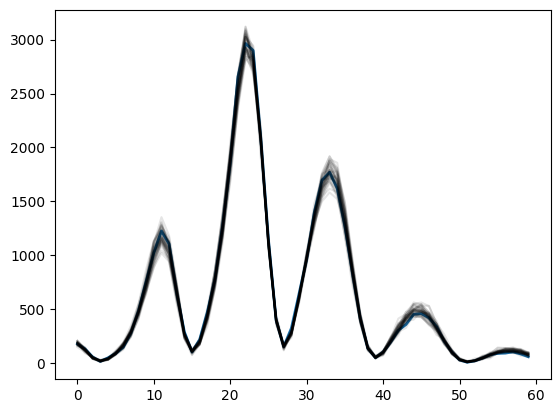

In [ ]:
# Plot observed data again
plt.figure()
plt.plot(data[:, 5], linewidth=2)

for _ in range(40):
    out = sir_out(target_vector)
    plt.plot(out[:, 5], color=(0, 0, 0, 0.1))

plt.show()

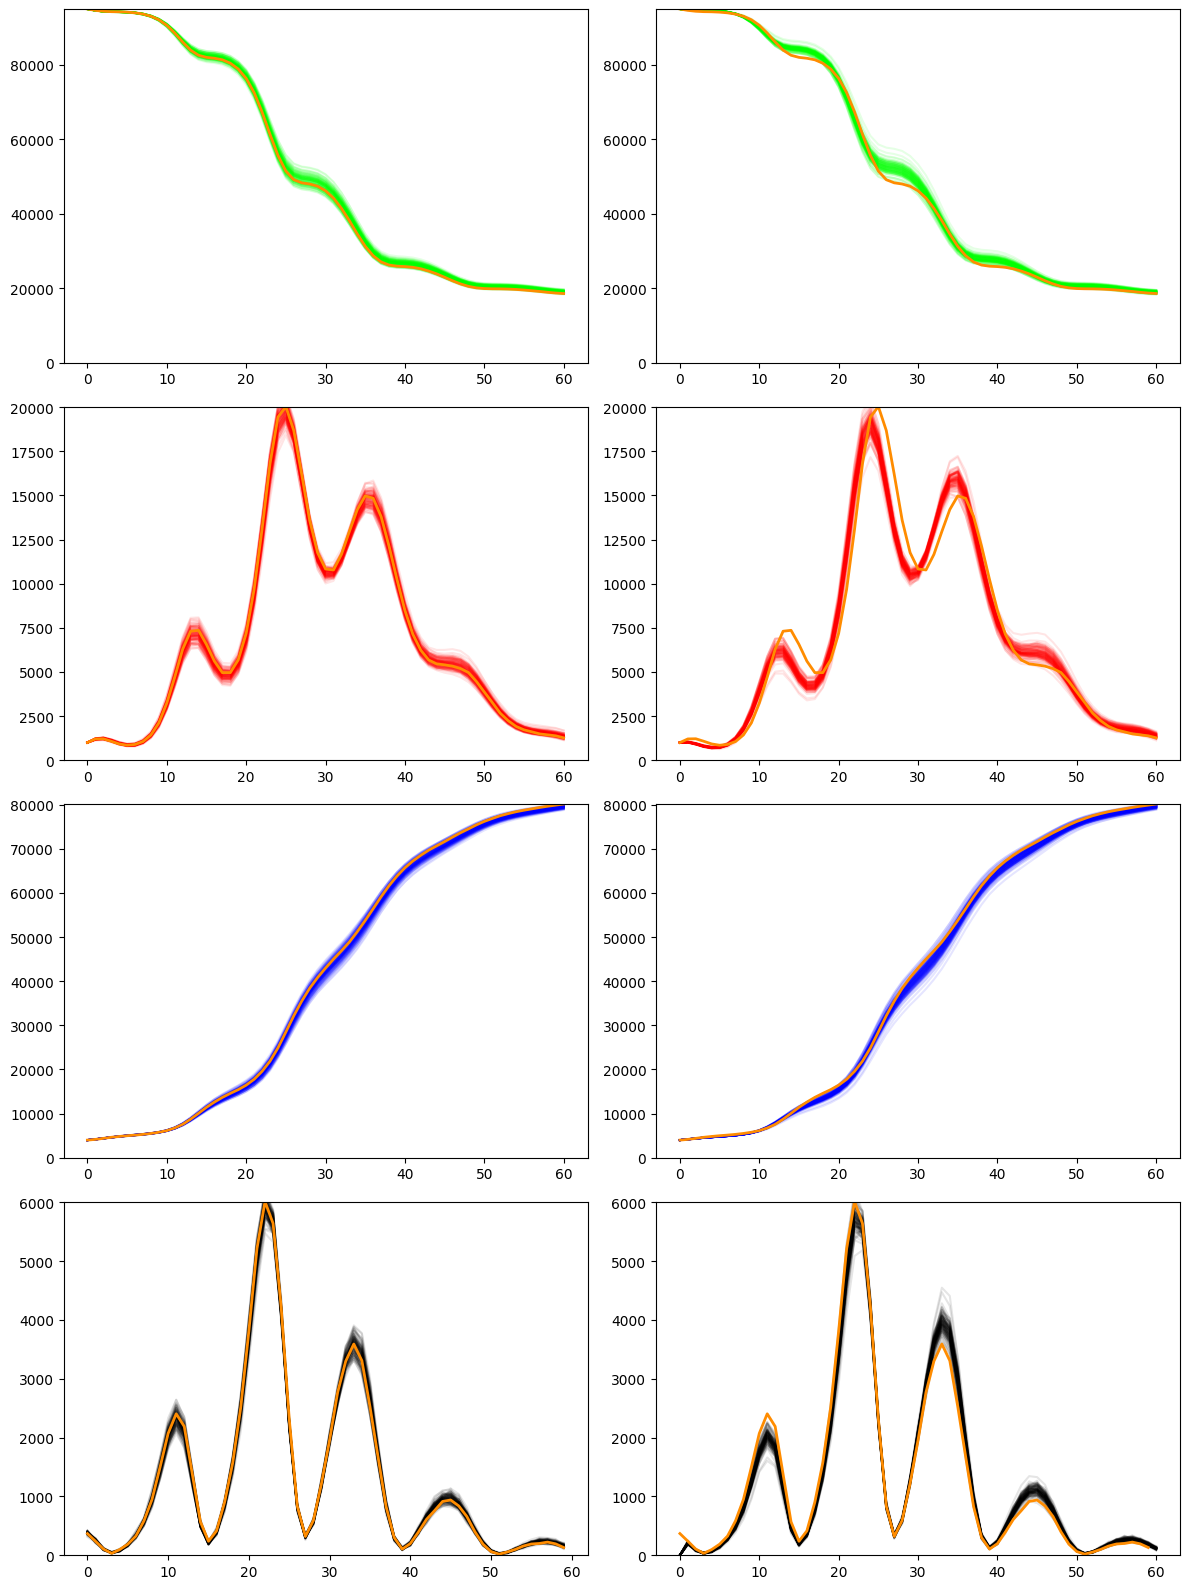

In [ ]:

# Generate list of SIR outputs for each particle
data_list = [sir_out(target_vector) for _ in range(DEFAULT_NUM_PARTICLES)]

# Initialize array and simulate for all particles across time steps
sir_out_all_months = initialize_array(target_vector)  # shape: (DEFAULT_NUM_PARTICLES, DEFAULT_NUM_TIME_STEPS+1, 4)

for month_step in range(DEFAULT_NUM_TIME_STEPS):
    sir_out_all_months[:, month_step + 1, :] = run_one_timestep(
        current_latent_states=sir_out_all_months[:, month_step, :],
        which_month=month_step + 1,
        params=target_vector,
    )

# Setup 4 rows x 2 columns of plots
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
axs = axs.flatten()

colors = [
    (0, 1, 0, 0.1),  # green transparent
    (0, 1, 0, 0.1),  # green transparent
    (1, 0, 0, 0.1),  # red transparent
    (1, 0, 0, 0.1),  # red transparent
    (0, 0, 1, 0.1),  # blue transparent
    (0, 0, 1, 0.1),  # blue transparent
    (0, 0, 0, 0.1),  # black transparent
    (0, 0, 0, 0.1),  # black transparent
]

for i, col in enumerate([0, 0, 1, 1, 2, 2, 3, 3]):
    # Determine which list to draw from (even indices: data_list, odd: sir_out_all_months)
    if i % 2 == 0:
        for p_num in range(DEFAULT_NUM_PARTICLES):
            axs[i].plot(data_list[p_num][:, col], color=colors[i])
    else:
        for p_num in range(DEFAULT_NUM_PARTICLES):
            axs[i].plot(sir_out_all_months[p_num, :, col], color=colors[i])

    # Plot data line
    # axs[i].plot(data[:, col], color=["green", "green", "red", "red", "blue", "blue", "black", "black"][i], linewidth=2)
    axs[i].plot(data[:, col], color="darkorange", linewidth=2)
    axs[i].set_ylim(0, np.nanmax(data[:, col]))

plt.tight_layout()
plt.show()
